TODO
1. extract features by googlenet
2. compute similarity
3. test on Place dataset

Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/places205 loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/activeloop/places205.
(256, 256, 3)


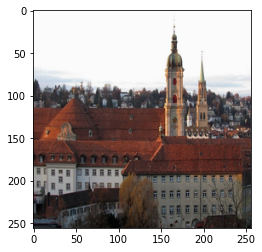

In [9]:
# load places205 dataset
import hub
ds = hub.load("hub://activeloop/places205")
dataloader = ds.pytorch(num_workers = 2, shuffle = False, batch_size= 4)

import numpy as np
img = ds.images[0].numpy()
print(img.shape)

import matplotlib.pyplot as plt
plt.imshow(img)
# images=ds.images[0:244].numpy()

In [1]:
import torch
import torch.nn as nn
from googlenet_places205 import GoogLeNetPlaces205

model = GoogLeNetPlaces205()
model.load_state_dict(torch.load("googlenet_places205.pth"))

# define hook
features = {}
def get_middle_output(name):
    def hook(model, input, output):
        features[name] = (output.detach())
    return hook

# model.inception_3b_5x5.register_forward_hook(get_middle_output('icp1'))
model.inception_4b_5x5.register_forward_hook(get_middle_output('icp1'))

In [120]:
import os
from PIL import Image
from torchvision import transforms

def preprocess_singe_img(filename):
    input_image = Image.open(filename)
    transform = transforms.Compose([
        transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = transform(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    return input_batch,np.array(input_image)

def get_features(input):
    output = model(input)
    return features['icp1'].flatten()

def get_similarity(input1, input2):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    return cos(input1, input2)


def process_images_from_folder(folder):
    image_features = []
    images=[]
    for filename in os.listdir(folder):
        if filename is not None:
            input,image = preprocess_singe_img(folder + '/' + filename)
            images.append(image)
            image_features.append(get_features(input))
    return image_features,images

# filename = ["images/road.png", "images/road2.png", "images/rail.png", "images/rail2.png"]
# outputs = []
# for img in filename:
#     input = preprocess(img)
#     outputs.append(get_features(input))

In [127]:
from skimage.feature import hog
from skimage import exposure
def hog_preprocess_singe_img(filename):
    input_image = Image.open(filename)
    transform = transforms.Compose([
        transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Grayscale(num_output_channels=1),
    ])
    input_tensor = transform(input_image)
    # input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    return input_tensor,np.array(input_image)

def get_hog_features(input):
    fd = hog(input.squeeze(), orientations=10, pixels_per_cell=(6, 6),
            cells_per_block=(1, 1))
    # print(fd.shape)
    return fd



def hog_process_images_from_folder(folder):
    image_features = []
    images=[]
    for filename in os.listdir(folder):
        if filename is not None:
            input,image = hog_preprocess_singe_img(folder + '/' + filename)
            image_features.append(get_hog_features(input))
            images.append(image)
    return image_features,images

database = "images/database"
query = "images/query"
hog_database_features,hog_database_images = hog_process_images_from_folder(database)
hog_query_features,hog_query_images =  hog_process_images_from_folder(query)

In [128]:
def visualize(database_images,query_images,similarity_matrix,query_num=10):
    matches=np.argmax(similarity_matrix,axis=1)
    # query_num=len(query_images)
    fig, ax = plt.subplots(query_num, 2, figsize= (8,60)) 
    fig.tight_layout()
    for i in range(query_num):
        ax[i, 0].imshow(query_images[i])
        ax[i, 0].set_title(i)
        ax[i, 1].imshow(database_images[matches[i]])
        ax[i, 1].set_title(matches[i])
    fig.show()


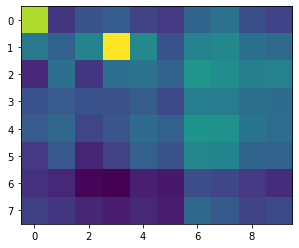

In [129]:
hog_similarity_matrix = np.zeros((len(hog_query_features), len(hog_database_features))) # Q by D

for i in range(len(hog_query_features)):
    for j in range(len(hog_database_features)):
        hog_similarity_matrix[i][j] = get_similarity(torch.from_numpy(hog_query_features[i]), torch.from_numpy(hog_database_features[j]))


plt.imshow(hog_similarity_matrix[:-2])
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12672\436049030.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


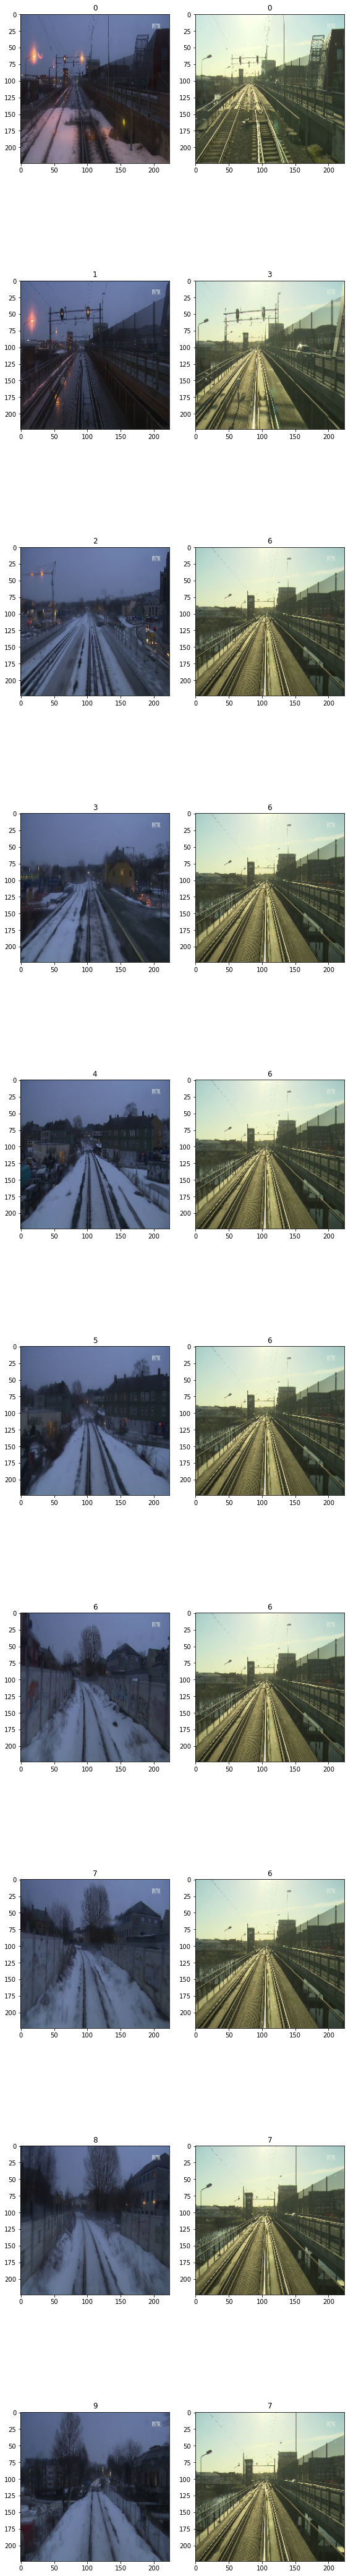

In [130]:
visualize(hog_database_images,hog_query_images,hog_similarity_matrix)

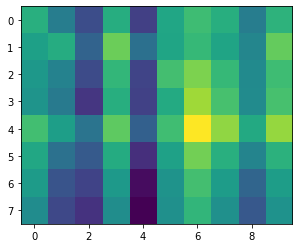

In [131]:
import numpy as np

database = "images/database"
query = "images/query"

database_features,database_images = process_images_from_folder(database)
query_features,query_images = process_images_from_folder(query)

similarity_matrix = np.zeros((len(hog_query_features), len(database_features))) # Q by D

for i in range(len(query_features)):
    for j in range(len(database_features)):
        similarity_matrix[i][j] = get_similarity(query_features[i], database_features[j])

# print(query_features[9])
# print(database_features[9])
# print(similarity_matrix)
plt.imshow(similarity_matrix[:-2])
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12672\436049030.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


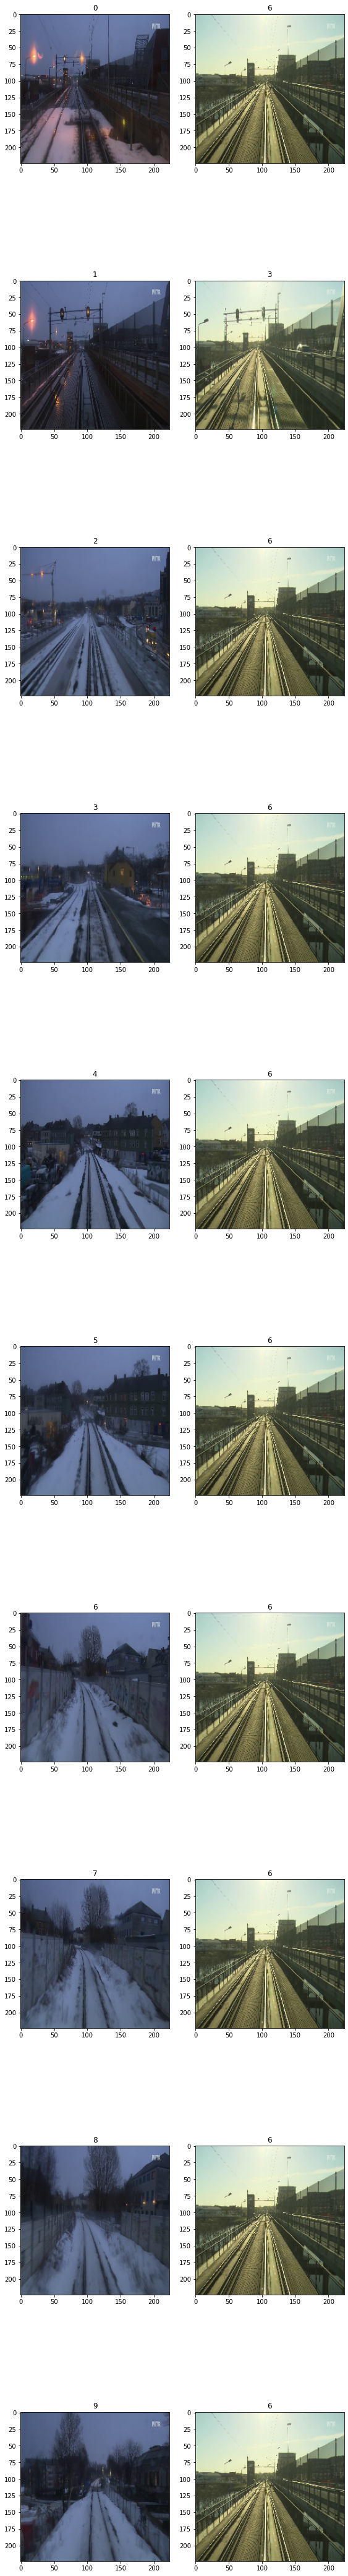

In [132]:
visualize(database_images,query_images,similarity_matrix)